In [1]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jun  5 11:26:48 2020

@author: TUDelft SID
"""

import numpy as np
import pandas as pd
from steady_BEM import steady_BEM
import matplotlib.pyplot as plt
from IPython.display import clear_output

def pitt_peters(Ct,vind,Uinf,R,dt,glauert=True ):
    # this function determines the time derivative of the induction at the annulli 
    # Ct is the thrust coefficient on the actuator, vind is the induced velocity, 
    # Uinf is the unperturbed velocity and R is the radial scale of the flow, nd dt is the time step
    # it returns the new value of induction vindnew and the time derivative dvind_dt
    # glauert defines if glauert's high load correction is applied
    a=-vind/Uinf # determine the induction coefficient for the time step {i-1}
    Ctn= -CTfunction(a, glauert) # calculate the thrust coefficient from the induction for the time step {i-1}
    dvind_dt =  (Ct-Ctn)/(16/(3*np.pi))*(Uinf**2/R) # calculate the time derivative of the induction velocity
    vindnew = vind + dvind_dt*dt # calculate the induction at time {i} by time integration
    return vindnew, dvind_dt

def oye_dynamic_inflow(vz, Ct1, Ct2, vint, Uinf, R, r,dt,glauert=True):
    # this function determines the time derivative of the induction at the annulli
    # using the Øye dynamic inflow model
    # Ct is the thrust coefficient on the actuator, vind is the induced velocity, 
    # Uinf is the unperturbed velocity and R is the radial scale of the flow,
    # r is the radial position of the annulus. vqs is the quasi-steady value from BEM, 
    #vint is an intermediate value and vz is the induced velocity
    
    # calculate  quasi-steady induction velocity
    vqst1=-ainduction(-Ct1)*Uinf

    # calculate current induction factor
    a=-vz/Uinf

    # calculate time scales of the model
    t1 = 1.1/(1-1.3*a)*R/Uinf
    t2 = (0.39-0.26*(r/R)**2)*t1

    # calculate next-time-step quasi-steady induction velocity
    vqst2=-ainduction(-Ct2)*Uinf
        
    #calculate time derivative of intermediate velocity
    dvint_dt= (vqst1+ (vqst2-vqst1)/dt*0.6*t1 - vint)/t1

    # calculate new intermediate velocity
    vint2 = vint +dvint_dt*dt
    
    #calculate time derivaive of the induced velocity
    dvz_dt = ((vint+vint2)/2-vz)/t2
    
    #calculate new induced velocity
    vz2 = vz +dvz_dt*dt
    
    return vz2, vint2

def larsenmadsen(vz, Ct2, Uinf, R,dt,glauert=True):
    # this function determines the time derivative of the induction at the annulli
    # using the Larsen-Madsen dynamic inflow model
    # Ct2 is the thrust coefficient on the actuator at the next time step, 
    # vind is the induced velocity, 
    # Uinf is the unperturbed velocity and R is the radial scale of the flow,
    # R is the radius. vqst2 is the quasi-steady value from momentum theory, 
    
    # calculate velocity wake 
    Vwake=Uinf+vz

    # calculate time scales of the model
    t1 = 0.5*R/Vwake

    # calculate next-time-step quasi-steady induction velocity
    vqst2=-ainduction(-Ct2)*Uinf
    
    #calculate new induced velocity
    vz2 = vz*np.exp(-dt/t1)+vqst2*(1-np.exp(-dt/t1))
    
    return vz2


def CTfunction(a, glauert = True):
    """
    This function calculates the thrust coefficient as a function of induction factor 'a'
    'glauert' defines if the Glauert correction for heavily loaded rotors should be used; default value is false
    """
    CT = np.zeros(np.shape(a))
    CT = 4*a*(1-a)  
    if glauert:
        CT1=1.816;
        a1=1-np.sqrt(CT1)/2;
        CT[a>a1] = CT1-4*(np.sqrt(CT1)-1)*(1-a[a>a1])
    
    return CT
  
    
def ainduction(CT):
    """
    This function calculates the induction factor 'a' as a function of thrust coefficient CT 
    including Glauert's correction
    """
    a = np.zeros(np.shape(CT))
    CT1=1.816;
    CT2=2*np.sqrt(CT1)-CT1
    a[CT>=CT2] = 1 + (CT[CT>=CT2]-CT1)/(4*(np.sqrt(CT1)-1))
    a[CT<CT2] = 0.5-0.5*np.sqrt(1-CT[CT<CT2])
    return a

def PrandtlTipRootCorrection(r_R, rootradius_R, tipradius_R, TSR, NBlades, axial_induction):
    """
    This function calcualte steh combined tip and root Prandtl correction at agiven radial position 'r_R' (non-dimensioned by rotor radius), 
    given a root and tip radius (also non-dimensioned), a tip speed ratio TSR, the number lf blades NBlades and the axial induction factor
    """
    temp1 = -NBlades/2*(tipradius_R-r_R)/r_R*np.sqrt( 1+ ((TSR*r_R)**2)/((1-axial_induction)**2))
    Ftip = np.array(2/np.pi*np.arccos(np.exp(temp1)))
    Ftip[np.isnan(Ftip)] = 0
    temp1 = NBlades/2*(rootradius_R-r_R)/r_R*np.sqrt( 1+ ((TSR*r_R)**2)/((1-axial_induction)**2))
    Froot = np.array(2/np.pi*np.arccos(np.exp(temp1)))
    Froot[np.isnan(Froot)] = 0
    return Froot*Ftip, Ftip, Froot

def loadBladeElement(vnorm, vtan, r_R, chord, twist, polar_alpha, polar_cl, polar_cd):
    """
    calculates the load in the blade element
    """
    vmag2 = vnorm**2 + vtan**2
    inflowangle = np.arctan2(vnorm,vtan)
    alpha = twist + inflowangle*180/np.pi
    cl = np.interp(alpha, polar_alpha, polar_cl)
    cd = np.interp(alpha, polar_alpha, polar_cd)
    lift = 0.5*vmag2*cl*chord
    drag = 0.5*vmag2*cd*chord
    fnorm = lift*np.cos(inflowangle)+drag*np.sin(inflowangle)
    ftan = lift*np.sin(inflowangle)-drag*np.cos(inflowangle)
    gamma = 0.5*np.sqrt(vmag2)*cl*chord
    return fnorm , ftan, gamma

def solveStreamtube(U_time, r1_R, r2_R, rootradius_R, tipradius_R , Omega, Radius, NBlades,
                    chord, twist_no_pitch, polar_alpha, polar_cl, polar_cd, time, 
                    pitch_array, initial_cond, model='pitt_peters' ):
    """
    solve balance of momentum between blade element load and loading in the streamtube
    input variables:
    U_time - wind speed over time
    r1_R,r2_R - edges of blade element, in fraction of Radius ;
    rootradius_R, tipradius_R - location of blade root and tip, in fraction of Radius ;
    Radius is the rotor radius
    Omega -rotational velocity
    NBlades - number of blades in rotor
    
    initial_cond = np.array([a_init, ap_init, fnorm_init, ftan_init, gamma_init, Ct_init, Prandtl_init])
    """
    Area = np.pi*((r2_R*Radius)**2-(r1_R*Radius)**2) #  area streamtube
    r_R = (r1_R+r2_R)/2 # centroide
    # initiatlize variables as the initial conditions
    a = initial_cond[0] # axial induction
    aline = initial_cond[1] # tangential induction factor
    
    #define the maximum number of iterations per time step
    Niterations = 100
    
    #define some empty arrays which house the results in time
    a_time = np.zeros(len(time))
    ap_time = np.zeros(len(time))
    fnorm_time = np.zeros(len(time))
    ftan_time = np.zeros(len(time))
    gamma_time = np.zeros(len(time))
    Ct_time = np.zeros(len(time))
    
    #add the initial conditions to these arrays
    a_time[0] = initial_cond[0]
    ap_time[0] = initial_cond[1]
    fnorm_time[0] = initial_cond[2]
    ftan_time[0] = initial_cond[3]
    gamma_time[0] = initial_cond[4]    
    Ct_time[0] = initial_cond[5]
    Prandtl = initial_cond[6]
    
    #find the value for dt
    dt = time[1]-time[0]
    
    Erroriterations =0.000001*dt #relative change in induction factor
    
    #if the model is oye, a intermediate velocity is required, multiply with the value
    #of the Prandtl tip corrections to make sure the correct induced velocity is calculated
    if model == 'oye':
        vint = -a_time[0]*U_time[0]*Prandtl
    
    #run through the time vector
    for j in range(len(time)):
        #add the pitch of the current timestep to the twist
        twist = twist_no_pitch+pitch_array[j]
#         if j==0:
#             a = 0.1
#             aline = 0.1
            
        for i in range(Niterations):
            # ///////////////////////////////////////////////////////////////////////
            # // this is the block "Calculate velocity and loads at blade element"
            # ///////////////////////////////////////////////////////////////////////
            Urotor = U_time[j]*(1-a) # axial velocity at rotor
            Utan = (1+aline)*Omega*r_R*Radius # tangential velocity at rotor
            # calculate loads in blade segment in 2D (N/m)
            fnorm, ftan, gamma = loadBladeElement(Urotor, Utan, r_R,chord, twist, polar_alpha, polar_cl, polar_cd)
            load3Daxial =fnorm*Radius*(r2_R-r1_R)*NBlades # 3D force in axial direction
            # load3Dtan =loads[1]*Radius*(r2_R-r1_R)*NBlades # 3D force in azimuthal/tangential direction (not used here)

            # ///////////////////////////////////////////////////////////////////////
            # //the block "Calculate velocity and loads at blade element" is done
            # ///////////////////////////////////////////////////////////////////////

            # ///////////////////////////////////////////////////////////////////////
            # // this is the block "Calculate new estimate of axial and azimuthal induction"
            # ///////////////////////////////////////////////////////////////////////
            # // calculate thrust coefficient at the streamtube 
            CT = load3Daxial/(0.5*Area*U_time[j]**2)

            # calculate new axial induction, accounting for Glauert's correction
            #anew =  ainduction(CT)
            #note that the vind is multiplied with the Prandtl tip correction to make sure the correct
            #value for vind by the force produced by the blade section is calculated, this will later 
            #be corrected again with the Prandtl tip correction.
            if model == 'pitt_peters':
                vind,dvind_dt = pitt_peters(np.array([-CT]),np.array([-a_time[j-1]*U_time[j-1]*Prandtl]),U_time[j],Radius,dt)
            elif model == 'oye':
                vind,vint_new=oye_dynamic_inflow(np.array([-a_time[j-1]*U_time[j-1]*Prandtl]), np.array([-Ct_time[j-1]]), np.array([-CT]), vint, U_time[j], Radius, r_R*Radius,dt) 
            elif model == 'larsen_madsen':
                vind = larsenmadsen(np.array([-a_time[j-1]*U_time[j-1]*Prandtl]), np.array([-CT]), U_time[j], Radius,dt)
            else:
                raise ValueError('Model not recognized')
            
            #find the new axial induction factor 
            anew = -vind[0]/U_time[j]
            
            # correct new axial induction with Prandtl's correction
            Prandtl, Prandtltip, Prandtlroot = PrandtlTipRootCorrection(r_R, rootradius_R, tipradius_R, Omega*Radius/U_time[j], NBlades, anew);

            if (Prandtl < 0.0001):  
                Prandtl = 0.0001 # avoid divide by zero
                            
            anew = anew/Prandtl # correct estimate of axial induction
            a = 0.0*a+1.0*anew # since the initial guess of this timestep will be the value for induction of 
                               # the previous timestep, the weigthing is not done to speed up the code
                            
            # calculate aximuthal induction
            aline_new = ftan*NBlades/(2*np.pi*U_time[j]*(1-a)*Omega*2*(r_R*Radius)**2)
            aline_new =aline_new/Prandtl # correct estimate of azimuthal induction with Prandtl's correction
            aline = aline_new
#            aline = aline*0.95+aline_new*0.05
            # ///////////////////////////////////////////////////////////////////////////
            # // end of the block "Calculate new estimate of axial and azimuthal induction"
            # ///////////////////////////////////////////////////////////////////////
            
            #// test convergence of solution, by checking convergence of axial induction
            if (np.abs((a-anew)/a) < Erroriterations): 
                # print("iterations")
                # print(i)
                break
        #if the model is oye, define the new intermediate velocity from this timestep after converged
        if model == 'oye':
            vint = vint_new*1
        #notify the user if the timestep has not converged
        if i == Niterations-1:
            print('Not converged')
        #save the results from this timestep before moving on to the next
        a_time[j] = a
        ap_time[j] = aline
        fnorm_time[j] = fnorm
        ftan_time[j] = ftan
        gamma_time[j] = gamma
        Ct_time[j] = CT
    
    #return the results
    return a_time,ap_time,fnorm_time,ftan_time,gamma_time,Ct_time


class unsteady_BEM:
    def __init__(self, airfoil, TipLocation_R, RootLocation_R, NBlades, Radius, Uinf, 
                 TSR, N_blade_sec, polar_alpha, polar_cl, polar_cd, alpha0, spacing = 'cosine'):
        self.airfoil = airfoil
        self.NBlades = NBlades
        self.Radius = Radius
        self.Uinf = Uinf
        self.Omega = TSR*Uinf/Radius
        self.N_blade_sec = N_blade_sec
        self.RootLocation_R = RootLocation_R
        self.TipLocation_R = TipLocation_R
        #create the blade division
        if spacing == 'cosine':
            beta_cosine = np.linspace(0,np.pi,N_blade_sec+1)
            self.r_R_dist = RootLocation_R+(TipLocation_R-RootLocation_R)/2*(1-np.cos(beta_cosine))
        elif spacing == 'uniform':
            self.r_R_dist = np.linspace(RootLocation_R,TipLocation_R,N_blade_sec+1)
        else:
            raise ValueError('Spacing method not recognized, please select either "cosine" or "uniform"')
        
        self.r_R_cent = np.zeros(N_blade_sec)
        #get the normalized radial locations of the blade sections
        for i in range(N_blade_sec):
            self.r_R_cent[i] = (self.r_R_dist[i]+self.r_R_dist[i+1])/2
        
        #define the twist distribution without pitch as well as the chord distribution
        self.twist_no_pitch = -14*(1-self.r_R_cent)
        self.chord_cent = 3*(1-self.r_R_cent)+1
        
        # set the polars - all data is in degrees!
        self.polar_alpha = polar_alpha
        self.polar_cl = polar_cl
        self.polar_cd = polar_cd
        self.alpha0 = alpha0
        
        #initialize the steady BEM class
        self.B_steady = steady_BEM(airfoil, TipLocation_R, RootLocation_R, NBlades, Radius, Uinf, TSR, N_blade_sec, spacing=spacing)

        self.pitch_ct = np.genfromtxt('pitch_ct.csv', delimiter=',')
        
    def find_pitch(self, CT):
        #find the value of the pitch given the steady CT
        return np.round(np.interp(CT, self.pitch_ct[:,1], self.pitch_ct[:,0]), 3)
    
    def get_solution(self, time, U_time, pitch, inflow_model = 'pitt_peters'):
        """ gets the solution for the unsteady BEM """
        self.time = time
        self.pitch_time = np.zeros(len(time)) + pitch
        self.U_time = U_time
        self.inflow_model = inflow_model
        
        #find the solution for the initial conditions with the steady solution
        start_CT,start_CP,start_results = self.B_steady.get_solution(self.pitch_time[0], self.U_time[0])
        
        #define some empty arrays that will house the results
        a_time_res = np.zeros([self.N_blade_sec,len(time)])
        ap_time_res = np.zeros([self.N_blade_sec,len(time)])
        fnorm_time_res = np.zeros([self.N_blade_sec,len(time)])
        ftan_time_res = np.zeros([self.N_blade_sec,len(time)])
        gamma_time_res = np.zeros([self.N_blade_sec,len(time)])
        Ct_time_res = np.zeros([self.N_blade_sec,len(time)])
        
        #find the width of each blade section
        dr = (self.r_R_dist[1:]-self.r_R_dist[:-1])*self.Radius
        
        #some empty arrays that house the absolute values for the thrust and the moment
        T_res = np.zeros([self.N_blade_sec,len(time)])
        M_res = np.zeros([self.N_blade_sec,len(time)])
        
        #run through each blade section and calculate the solution in time
        for i in range(self.N_blade_sec):
            clear_output(wait=True)
            print('we are at {}%'.format(round(i/self.N_blade_sec*100, 2)))
            #find the initial conditions
            initial_cond = np.array([start_results[i,0], start_results[i,1], start_results[i,2], start_results[i,3], start_results[i,4], start_results[i,6], start_results[i,7]])
            #call the function solveStreamtube with the given initial conditions and pitch in time
            a_time_res[i,:],ap_time_res[i,:],fnorm_time_res[i,:],ftan_time_res[i,:],gamma_time_res[i,:],Ct_time_res[i,:] = solveStreamtube(self.U_time, 
                       self.r_R_dist[i], self.r_R_dist[i+1], self.RootLocation_R, self.TipLocation_R , 
                       self.Omega, self.Radius, self.NBlades, self.chord_cent[i], self.twist_no_pitch[i], 
                       self.polar_alpha, self.polar_cl, self.polar_cd, time, self.pitch_time,
                       initial_cond, model=inflow_model )
            #save the absolute value for thrust and moment for each blade section
            T_res[i,:] = fnorm_time_res[i,:]*dr[i]
            M_res[i,:] = ftan_time_res[i,:]*dr[i]*self.r_R_cent[i]*self.Radius
        #sum all the values for thrust and moment along axis=0 to find the total thrust in time and normalize
        CT_res = np.sum(T_res,axis=0)*self.NBlades/(0.5*self.Uinf**2*np.pi*self.Radius**2)
        CP_res = np.sum(M_res,axis=0)*self.NBlades*self.Omega/(0.5*self.Uinf**3*np.pi*self.Radius**2)
        #add the inital conditions to the CT and CP
        CT_res[0] = start_CT
        CP_res[0] = start_CP
        #return the results
        return a_time_res,ap_time_res,fnorm_time_res,ftan_time_res,gamma_time_res,Ct_time_res, CT_res, CP_res        


we are at 90.0%


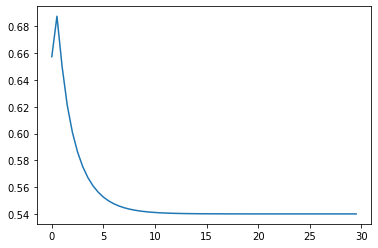

In [10]:
# define flow conditions
Uinf = 10 # unperturbed wind speed in m/s
TSR = 8 # tip speed ratio
Radius = 50
N_blade_sec = 10
NBlades = 3
TipLocation_R =  1
RootLocation_R =  0.2
pitch = 2
airfoil = 'DU_polar.txt'

#read in the polar of the airfoil
data1=pd.read_csv(airfoil, header=0, names = ["alfa", "cl", "cd", "cm"],  sep='\s+')
polar_alpha_visc = data1['alfa'][:]
polar_cl_visc = data1['cl'][:]
polar_cd_visc = data1['cd'][:]
alpha0 = np.interp(0, polar_cl_visc, polar_alpha_visc)

# set the dynamic stall polars
dCn_da = 2*np.pi
polar_alpha = np.arange(-5, 30, 0.1)
polar_cl = dCn_da*polar_alpha*np.pi/180
polar_cd = 0*polar_alpha*np.pi/180

B = unsteady_BEM(airfoil, TipLocation_R, RootLocation_R, NBlades, Radius, Uinf, TSR, 
                 N_blade_sec, polar_alpha, polar_cl, polar_cd, alpha0, spacing='cosine')

#create the time array
max_time = 30 #upper bound on the time vector
dt = 0.5
time = np.arange(0,max_time,dt)
U1_U0 = 1.0
deltaU = 0.5
omega_R_uinf = 0
azimuth = TSR*Uinf/Radius*time

# create velocity vector
U_time = np.zeros(len(time))+Uinf*U1_U0 #+ deltaU*np.cos(omega_R_uinf*time)*np.sin(azimuth)

# set inflow model
inflow_model = 'pitt_peters'

[a_s,ap_s,fnorm_s,ftan_s,gamma_s,Ct_s, CT_s, CP_s]=B.get_solution(time,U_time,pitch,inflow_model = inflow_model)


# _,_,steady_sol1 = B.B_steady.get_solution(B.pitch_time[0])
# _,_,steady_sol2 = B.B_steady.get_solution(B.pitch_time[-1])

# plt.plot(time_range,np.ones(len(time_range))*steady_sol1[0,0])
# plt.plot(time_range,np.ones(len(time_range))*steady_sol2[0,0])
plt.plot(time,CT_s)

# print(time_range[abs(a_time_res[0,:]-steady_sol2[0,0])/steady_sol2[0,0]<0.01][0])


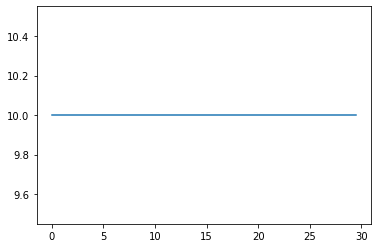

In [7]:
plt.plot(time, U_time)